# Segmentez des clients d'un site e-commerce - Essai

Pascaline Grondein

Début : 30/05/2022

<i/> Vous êtes consultant pour Olist, une entreprise brésilienne qui propose une solution de vente sur les marketplaces en ligne. </i>

<i/> Olist souhaite que vous fournissiez à ses équipes d'e-commerce une segmentation des clients qu’elles pourront utiliser au quotidien pour leurs campagnes de communication.

<i/>Votre objectif est de comprendre les différents types d’utilisateurs grâce à leur comportement et à leurs données personnelles.

<i/>Vous devrez fournir à l’équipe marketing une description actionable de votre segmentation et de sa logique sous-jacente pour une utilisation optimale, ainsi qu’une proposition de contrat de maintenance basée sur une analyse de la stabilité des segments au cours du temps.</i>

### Table of Contents

* [I. K-means](#chapter1)
    * [1. Appropriate number of clusters](#section_1_1)
        * [a. Méthode du coude](#section_1_1_1)
        * [b. Coefficient de silhouette](#section_1_1_2)
    * [2. Modèle avec meilleur k](#section_1_2)
* [II. Modèle hiérarchique](#chapter2)
    * [1. Déterminer le nombre de clusters](#section_2_1)
    * [2. Nombre de clusters = 5](#section_2_2)
* [III. DBScan](#chapter3)
* [IV. tSNE](#chapter4)
* [V. K-means : ajout de variables](#chapter5)
    * [1. Appropriate number of clusters (méthode du coude)](#section_5_1)
    * [2. Application Kmeans](#section_5_2)
    * [3. Visualisation](#section_5_3)

In [1]:
%matplotlib inline

import pandas as pd
pd.set_option('precision', 2)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import statsmodels.api as sm
import matplotlib.cm as cm

import time
from time import process_time

from kneed import KneeLocator
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import DBSCAN
from sklearn import metrics

from sklearn import (manifold, datasets, decomposition, ensemble,discriminant_analysis, random_projection)
from matplotlib import offsetbox
#from sklearn.datasets import fetch_mldata
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
from __future__ import print_function
import time

import warnings
warnings.filterwarnings("ignore")

#mpl.rcParams["figure.figsize"] = (9,9)

In [2]:
RFM_subset = pd.read_csv('RFM_subset.csv', index_col = 'Unnamed: 0')
RFM_MinMax = pd.read_csv('RFM_MinMax.csv', index_col = 'Unnamed: 0')
RFM_StandScal = pd.read_csv('RFM_StandScal.csv', index_col = 'Unnamed: 0')

Plus_MinMax = pd.read_csv('Plus_MinMax.csv', index_col = 'Unnamed: 0')
Plus_subset = pd.read_csv('Plus_subset.csv', index_col = 'Unnamed: 0')

subsets = ['RFM_subset', 'RFM_MinMax', 'RFM_StandScal']

In [3]:
#random state
rs = 42

# <a class="anchor" id="chapter1">I. K-Means </a>

## <a class="anchor" id="section_1_1">1. Appropriate number of clusters</a>

In [4]:
kmeans_kwargs = {
    "init" : "random",
    "n_init" : 10,
    "max_iter" : 300,
    "random_state" : rs,
}

Avant de se lancer dans un modèle K-means, il est bon de déterminer le nombre optimal de clusters. Deux méthodes s'offrent à nous: 
 - Méthode du coude
 - Méthode du coefficient de silhouette

### <a class="anchor" id="section_1_1_1">a. Méthode du coude</a>

Testons en premier la méthode du coude, sur les trois types de dataset.

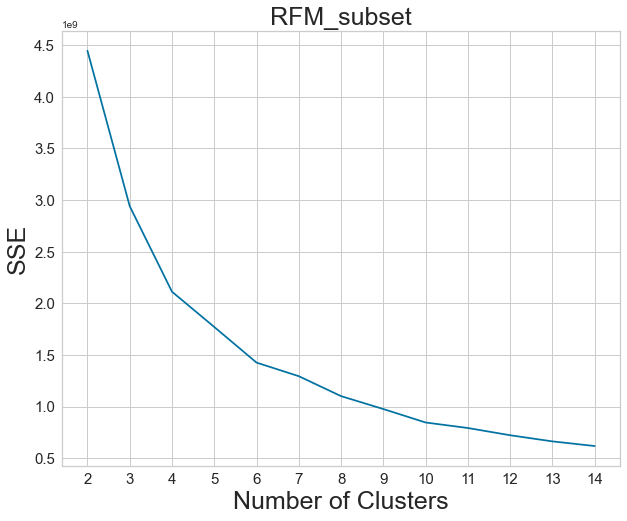

Le nombre de clusters optimal pour RFM_subset est 6


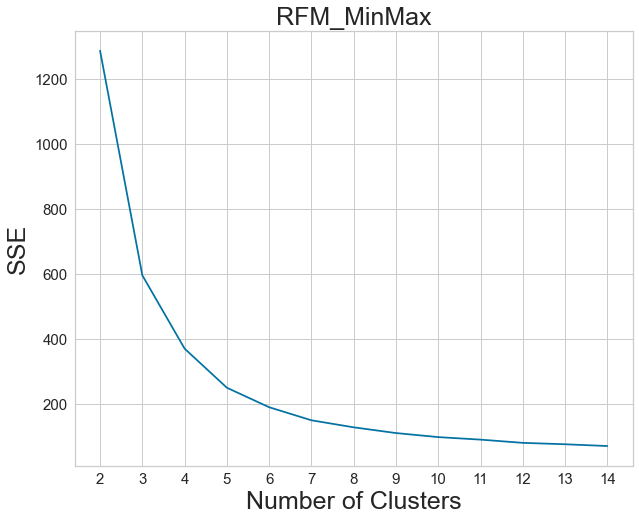

Le nombre de clusters optimal pour RFM_MinMax est 5


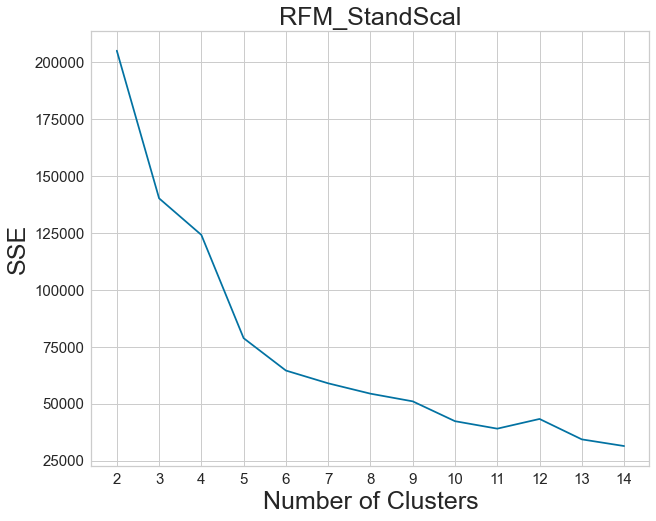

Le nombre de clusters optimal pour RFM_StandScal est 5


In [40]:
best_ks = pd.DataFrame()

for sub in subsets :
    if sub == 'RFM_subset' :
        X = RFM_subset
    if sub == 'RFM_MinMax' :
        X = RFM_MinMax
    if sub == 'RFM_StandScal' :
        X = RFM_StandScal
    
    sse = []

    for k in range(2, 15):
    
        kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
        kmeans.fit(X)
        sse.append(kmeans.inertia_)
        
    plt.figure(figsize=(10, 8))
    plt.plot(range(2, 15), sse)
    plt.xticks(range(2, 15), fontsize = 15)
    plt.yticks(fontsize = 15)
    plt.xlabel("Number of Clusters", fontsize = 25)
    plt.ylabel("SSE", fontsize = 25)
        
    plt.title(sub, fontsize = 25)     
        
    plt.show()
    
    kl = KneeLocator(
    range(2, 15), sse, curve = "convex", direction = "decreasing"
    )

    print('Le nombre de clusters optimal pour {} est {}'.format(sub, kl.elbow))
    
    best_k = pd.DataFrame(data = {'Best k' : kl.elbow}, index = [sub])
    best_ks = best_ks.append(best_k)

In [41]:
best_ks

,Best k
RFM_subset,6
RFM_MinMax,5
RFM_StandScal,5


On peut voir que le coude est le plus marqué pour le dataset scalé avec MinMax, avec une valeur optimale de k à 5. Je ne vais utiliser que ce dataset dans la suite. 

###  <a class="anchor" id="section_1_1_2">b. Coefficient de silhouette</a>

Confirmons le résultat précédent avec la méthode du coefficient de silhouette.

-------  RFM_subset  ------
------- k = 3  ------


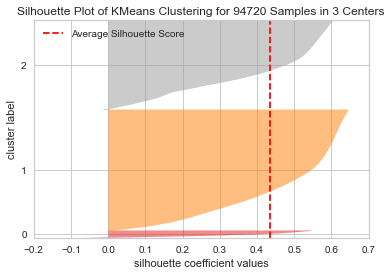

------- k = 4  ------


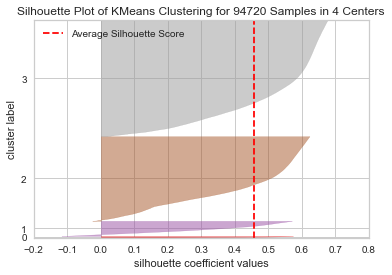

------- k = 5  ------


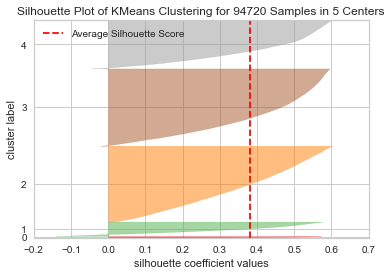

------- k = 6  ------


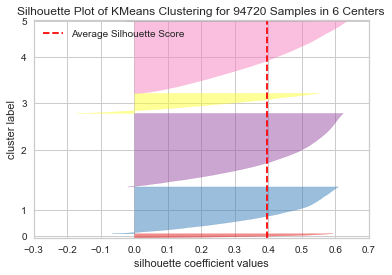

------- k = 7  ------


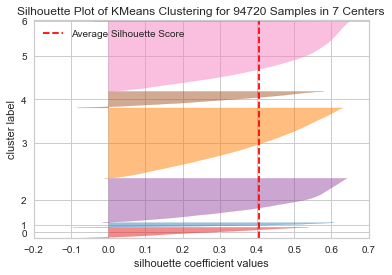

------- k = 10  ------


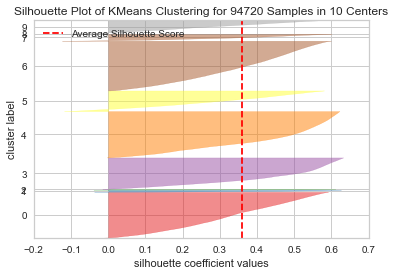

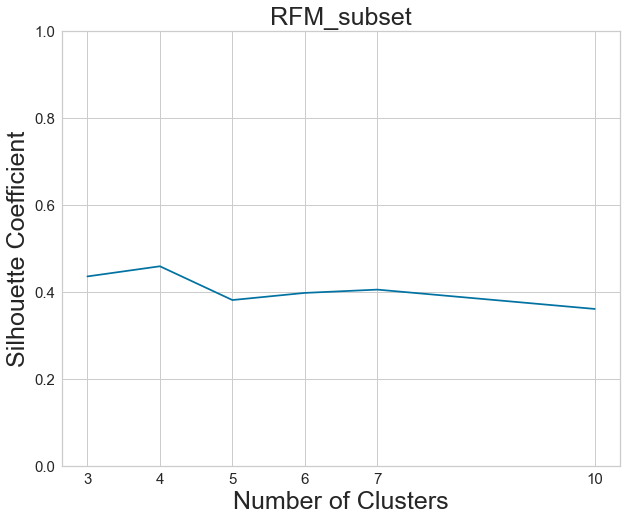

-------  RFM_MinMax  ------
------- k = 3  ------


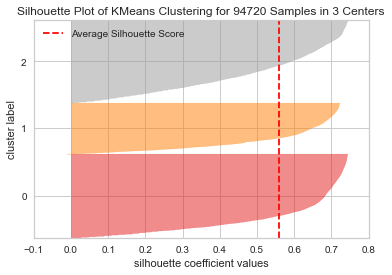

------- k = 4  ------


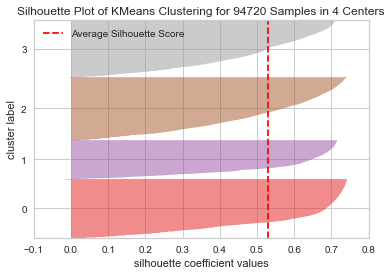

------- k = 5  ------


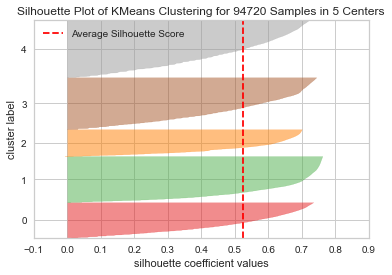

------- k = 6  ------


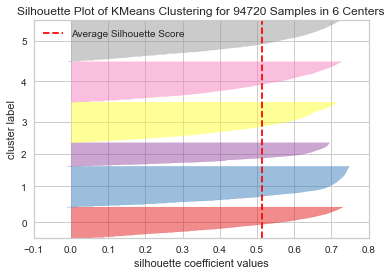

------- k = 7  ------


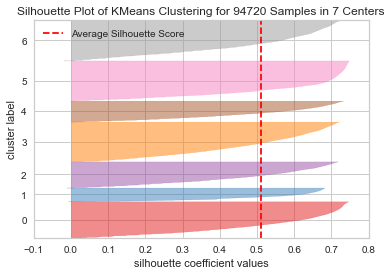

------- k = 10  ------


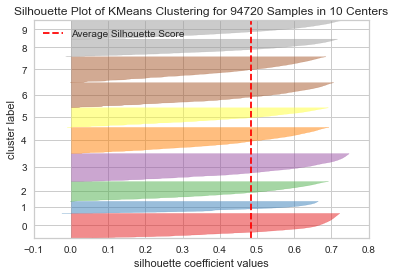

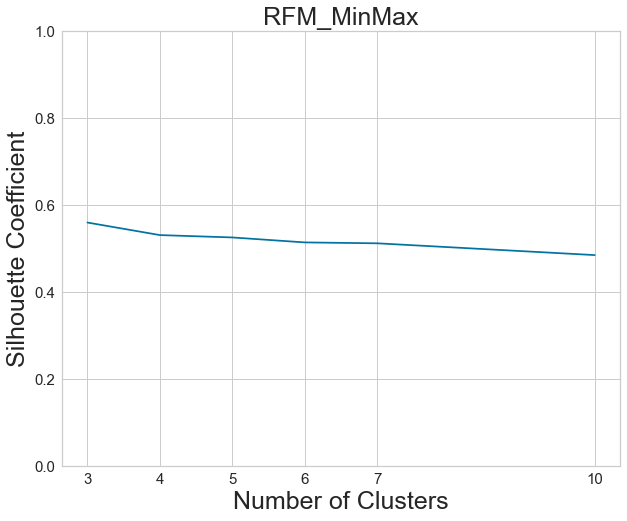

-------  RFM_StandScal  ------
------- k = 3  ------


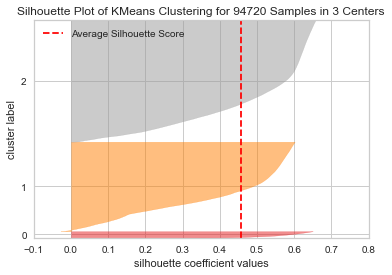

------- k = 4  ------


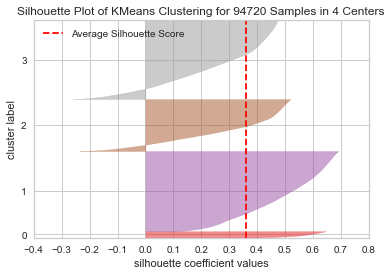

------- k = 5  ------


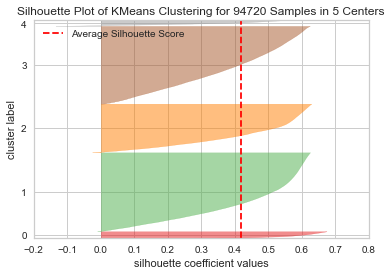

------- k = 6  ------


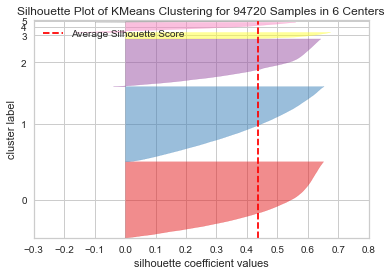

------- k = 7  ------


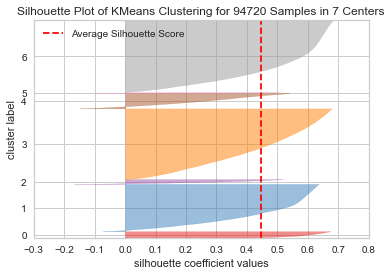

------- k = 10  ------


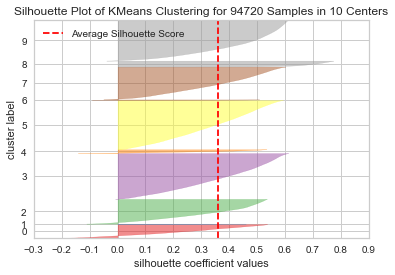

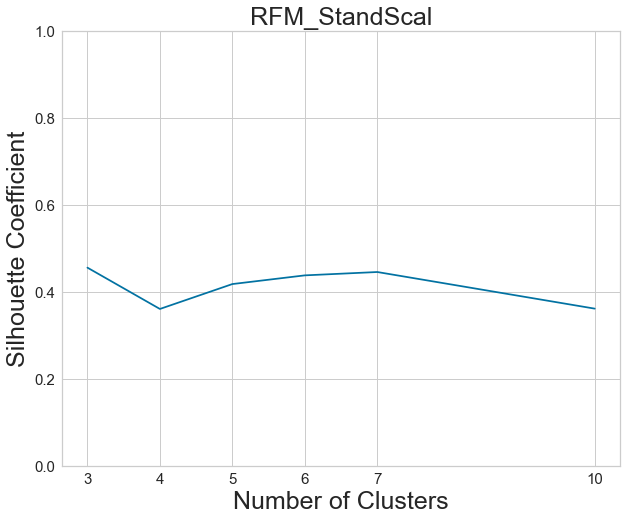

In [42]:
for sub in subsets:
    if sub == 'RFM_subset' :
        X = RFM_subset
    if sub == 'RFM_MinMax' :
        X = RFM_MinMax
    if sub == 'RFM_StandScal' :
        X = RFM_StandScal

    silhouette_coefficients = []
    print('------- ', sub, ' ------')

    for k in [3, 4, 5, 6, 7, 10] :
        
        print('------- k =', k, ' ------')
        
        kmeans = KMeans(n_clusters = k, **kmeans_kwargs)
        visualizer = SilhouetteVisualizer(kmeans)
        
        visualizer.fit(X)
        visualizer.poof()
        
        kmeans.fit(X)
        score = silhouette_score(X, kmeans.labels_)
        silhouette_coefficients.append(score)
    
    plt.figure(figsize = (10, 8))
    plt.plot([3, 4, 5, 6, 7, 10], silhouette_coefficients)
    plt.xticks([3, 4, 5, 6, 7, 10], fontsize = 15)
    plt.yticks(fontsize = 15)
    plt.ylim(0, 1)
    plt.xlabel("Number of Clusters", fontsize = 25)
    plt.ylabel("Silhouette Coefficient", fontsize = 25)
        
    plt.title(sub, fontsize = 25)
        
    plt.show()


Avec cette méthode, on constate que le nombre optimal de cluster se situe entre 3 et 7, ce qui corrobore le résultat obtenu avec la méthode du coude. Au delà de 7 clusters, l'analyse devient plus compliquée, et est plus compliquée à prendre en main niveau marketing.

## <a class="anchor" id="section_1_2">2. Application K-means avec meilleur k</a>

In [5]:
kmeans_kwargs = {
    "init" : "random",
    "n_init" : 10,
    "max_iter" : 300,
    "random_state" : rs,
}
k = 5

Appliquons maintenant le modèle Kmeans avec le nombre de clusters optimal pour les données scaled avec MinMax. 

In [29]:
kmeans = KMeans(n_clusters = k, **kmeans_kwargs)
kmeans.fit(RFM_MinMax)
    
print('La valeur SSE la plus basse est :', kmeans.inertia_)
print('Nombre de clusters :', k)
print('Il a fallu {} itérations.'.format(kmeans.n_iter_))

#Répartition des utilisateurs dans les clusters
unique, counts = np.unique(kmeans.labels_, return_counts = True)
clusters = pd.DataFrame(data = zip(unique + 1, counts), columns = ['Clusters', 'Nb of Users']).set_index('Clusters')
clusters['% users'] = round(clusters['Nb of Users'] / len(RFM_MinMax), 2)*100
display(clusters)
RFM_MinMax['Cluster'] = [x + 1 for x in kmeans.labels_]    

#Calcul des moyenens et écart-type des variables par 
Y = pd.read_csv('RFM_subset.csv', index_col = 'Unnamed: 0') 

Y['Cluster'] = [x + 1 for x in kmeans.labels_]        
cm_moy = sns.light_palette("red", as_cmap=True)
cm_std = sns.light_palette("blue", as_cmap=True)

print('-----')
print('Moyenne des variables par cluster')
moy = Y.groupby(by = ['Cluster'], axis = 0, as_index = False).mean().set_index('Cluster')
display(moy.style.background_gradient(cmap = cm_moy).set_precision(3))

print('-----')
print('Médiane des variables par cluster')
moy = Y.groupby(by = ['Cluster'], axis = 0, as_index = False).median().set_index('Cluster')
display(moy.style.background_gradient(cmap = cm_moy).set_precision(3))

print('-----')
print('Ecart-type des variables par cluster')
std = Y.groupby(by = ['Cluster'], axis = 0, as_index = False).std().set_index('Cluster')
display(std.style.background_gradient(cmap = cm_std).set_precision(3))
    
Y = Y.drop('Cluster', axis = 1)

La valeur SSE la plus basse est : 1132.5285749998682
Nombre de clusters : 5
Il a fallu 3 itérations.


,Nb of Users,% users
Clusters,,
1,20127,21.0
2,15454,16.0
3,12273,13.0
4,34330,36.0
5,12536,13.0


-----
Moyenne des variables par cluster


,Recence,Frequence,Montant
Cluster,,,
1,96.798,1.040,169.687
2,429.246,1.033,165.014
3,174.450,1.036,173.202
4,395.856,1.029,163.860
5,228.847,1.037,158.434


-----
Médiane des variables par cluster


,Recence,Frequence,Montant
Cluster,,,
1,92.000,1.000,110.770
2,428.000,1.000,105.220
3,174.000,1.000,112.020
4,333.000,1.000,106.810
5,229.000,1.000,107.945


-----
Ecart-type des variables par cluster


,Recence,Frequence,Montant
Cluster,,,
1,27.606,0.255,239.025
2,35.327,0.191,240.599
3,14.792,0.218,234.135
4,124.968,0.182,224.145
5,15.553,0.220,187.903


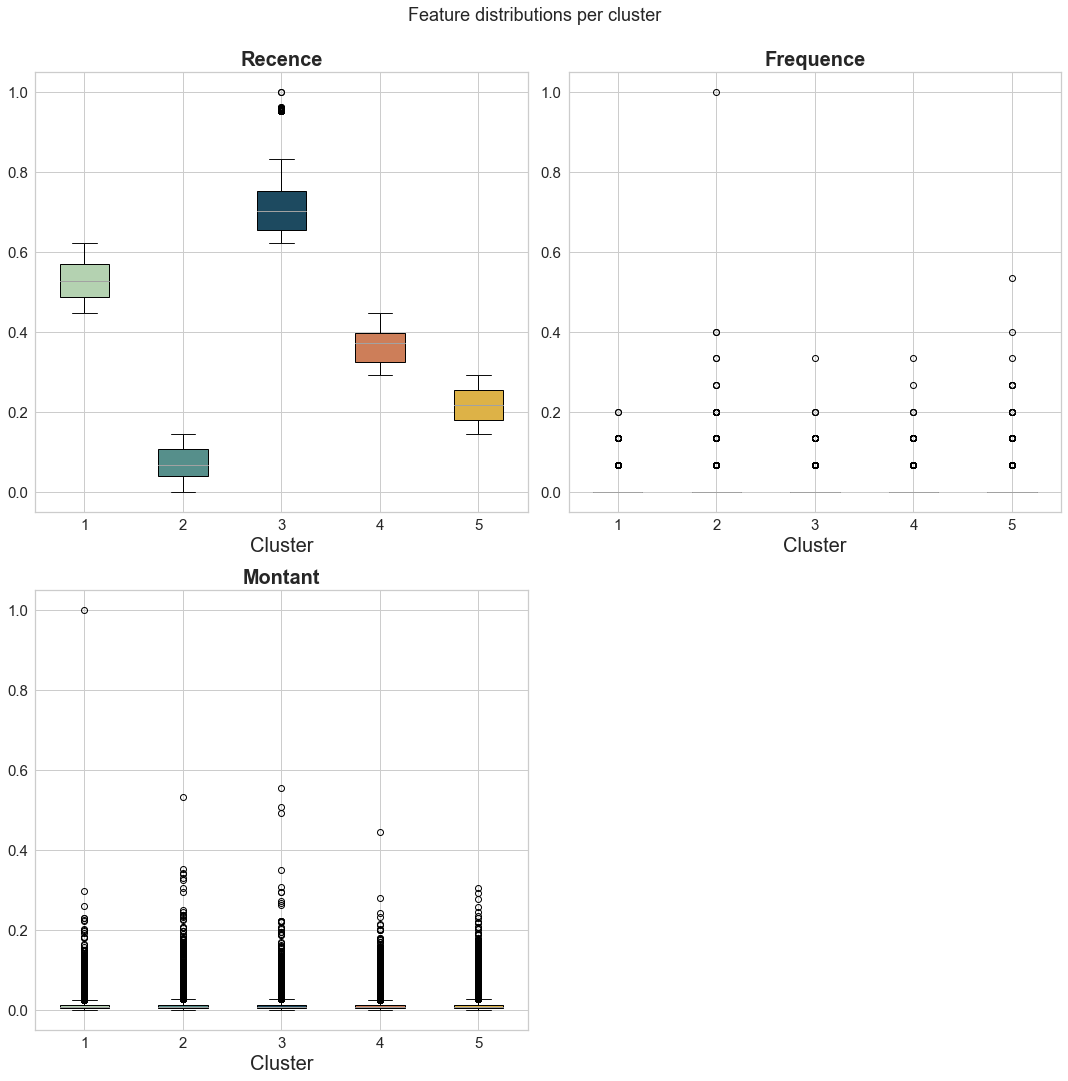

In [7]:
cluster_colors = ['#b4d2b1', '#568f8b', '#1d4a60', '#cd7e59', '#ddb247', '#d15252']

features = kmeans.feature_names_in_
ncols = 2
nrows = len(features) // ncols + (len(features) % ncols > 0)
fig = plt.figure(figsize=(15, 15))

for n, feature in enumerate(features):
    ax = plt.subplot(nrows, ncols, n + 1)
    box = RFM_MinMax[[feature, 'Cluster']].boxplot(by = 'Cluster', ax = ax, return_type = 'both', patch_artist = True)
    
    for row_key, (ax, row) in box.iteritems():
        ax.set_xlabel('Cluster', fontsize = 20)
        ax.set_title(feature, fontweight="bold", fontsize = 20)
        plt.xticks(fontsize = 15)
        plt.yticks(fontsize = 15)
        for i, box in enumerate(row['boxes']):
            box.set_facecolor(cluster_colors[i])
                
                
fig.suptitle('Feature distributions per cluster', fontsize=18, y=1)   
plt.tight_layout()
plt.show()                

Avec 5 clusters, on observe une répartition équilibrée des utilisateurs. Le groupe 2 apparaît comme celui avec la Fréquence, la Récense d'achat et le Montant les plus intéressants, avec l'écart-type le plus faible pour la Récense, le plus élevé pour la Fréquence et entre les deux pour le Montant. 

# <a class="anchor" id="chapter2">II. Modèle hiérarchique </a>

Testons maintenant la méthode agglomérative pour estimer le nombre de clusters. 

## <a class="anchor" id="section_2_1">1. Déterminer le nombre de clusters optimal</a>

In [8]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)
    
    #display(linkage_matrix)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
    

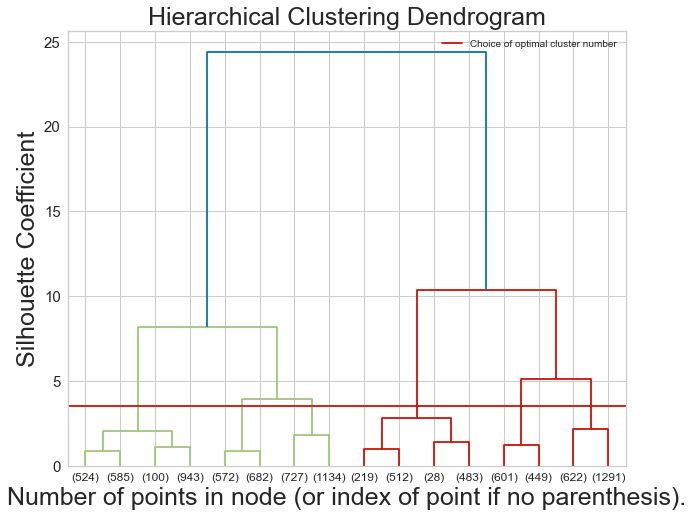

In [30]:
X = pd.read_csv('RFM_MinMax.csv', index_col = 'Unnamed: 0').sample(frac = 0.1)

# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold = 0, n_clusters = None)
model = model.fit(X)

plt.figure(figsize=(10, 8))
plt.title("Hierarchical Clustering Dendrogram", fontsize = 25)
plt.yticks(fontsize = 15)
plt.xlabel("Number of points in node (or index of point if no parenthesis).", fontsize = 25)
plt.ylabel("Silhouette Coefficient", fontsize = 25)
        
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode = "level", p = 3)
plt.axhline(y = 3.5, color = 'r', linestyle = '-', label = 'Choice of optimal cluster number')
plt.legend(fontsize = 10)
plt.show()

En observant ce dendogramme, on constate que 6 clusters (k = 6) semblent comme une option optimum pour notre échantillon du dataset. 

## <a class="anchor" id="section_2_2">2. Application du modèle </a>

In [31]:
# setting distance_threshold=0 ensures we compute the full tree.
AC = AgglomerativeClustering(distance_threshold = None, n_clusters = 6)
AC = AC.fit(X)
        
#Répartition des utilisateurs dans les clusters
unique, counts = np.unique(AC.labels_, return_counts = True)
clusters = pd.DataFrame(data = zip(unique + 1, counts), columns = ['Clusters','Nb of Users']).set_index('Clusters')
clusters['% users'] = round(clusters['Nb of Users']/len(X),2)*100
display(clusters)  

#Calcul des moyenens et écart-type des variables par 
#Y = RFM_subset
Y = RFM_subset.sample(frac = 0.1)
col = Y.columns

Y['Clusters'] = [x + 1 for x in AC.labels_]        
cm_moy = sns.light_palette("red", as_cmap = True)
cm_std = sns.light_palette("blue", as_cmap = True)

print('-----')
print('Moyenne des variables par cluster')
moy = Y.groupby(by = ['Clusters'], axis = 0, as_index = False).mean().set_index('Clusters')
display(moy.style.background_gradient(cmap = cm_moy).set_precision(3))

print('-----')
print('Médiane des variables par cluster')
moy = Y.groupby(by = ['Clusters'], axis = 0, as_index = False).median().set_index('Clusters')
display(moy.style.background_gradient(cmap = cm_moy).set_precision(3))

print('-----')
print('Ecart-type des variables par cluster')
std = Y.groupby(by = ['Clusters'],axis = 0, as_index = False).std().set_index('Clusters')
display(std.style.background_gradient(cmap = cm_std).set_precision(3))
    
Y = Y.drop('Clusters',axis = 1)

,Nb of Users,% users
Clusters,,
1,1242,13.0
2,1913,20.0
3,1861,20.0
4,2152,23.0
5,1050,11.0
6,1254,13.0


-----
Moyenne des variables par cluster


,Recence,Frequence,Montant
Clusters,,,
1,289.607,1.029,164.981
2,282.169,1.036,164.257
3,291.898,1.040,170.829
4,288.117,1.036,164.035
5,277.265,1.035,162.350
6,284.596,1.022,170.828


-----
Médiane des variables par cluster


,Recence,Frequence,Montant
Clusters,,,
1,266.000,1.000,108.140
2,267.000,1.000,108.880
3,273.000,1.000,103.850
4,269.000,1.000,111.180
5,261.000,1.000,102.395
6,270.000,1.000,108.515


-----
Ecart-type des variables par cluster


,Recence,Frequence,Montant
Clusters,,,
1,156.474,0.173,205.290
2,147.598,0.266,205.472
3,155.364,0.232,255.949
4,155.341,0.197,207.987
5,148.497,0.209,204.460
6,153.332,0.151,251.943


Le nombre de clients par cluster est équilibré. Cependant, il n'est pas possible d'appliquer ce modèle à la totalité du dataset, trop volumineux. Cette méthode n'est donc pas adaptée à notre cas.

# <a class="anchor" id="chapter3">III. DBSCAN </a>

Finalement, testons maintenant le modèle DBScan pour estimer le nombre de clusters du dataset.

In [11]:
X = pd.read_csv('RFM_MinMax.csv', index_col = 'Unnamed: 0').sample(frac = 0.3)

---- eps = 0.1  ---
Estimated number of clusters: 1
Estimated number of noise points: 108


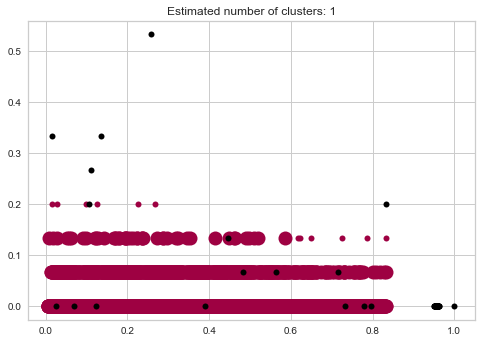

---- eps = 0.5  ---
Estimated number of clusters: 1
Estimated number of noise points: 0


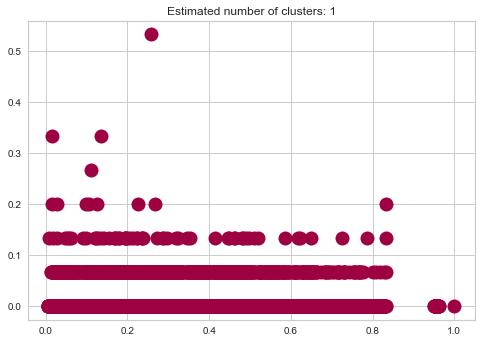

---- eps = 1  ---
Estimated number of clusters: 1
Estimated number of noise points: 0


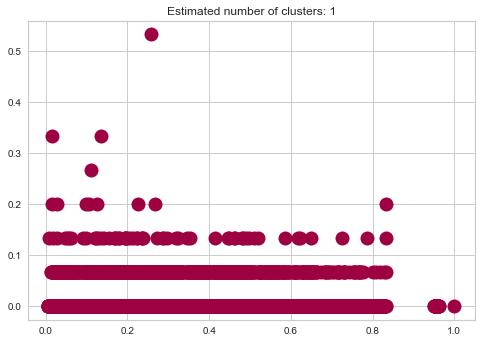

---- eps = 2  ---
Estimated number of clusters: 1
Estimated number of noise points: 0


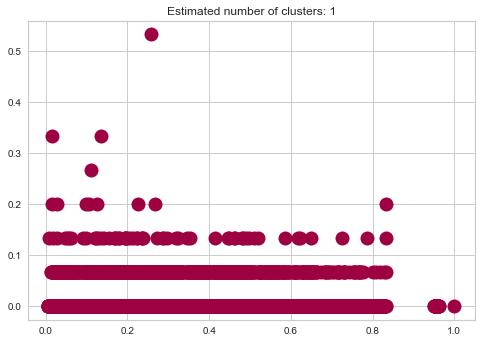

---- eps = 5  ---
Estimated number of clusters: 1
Estimated number of noise points: 0


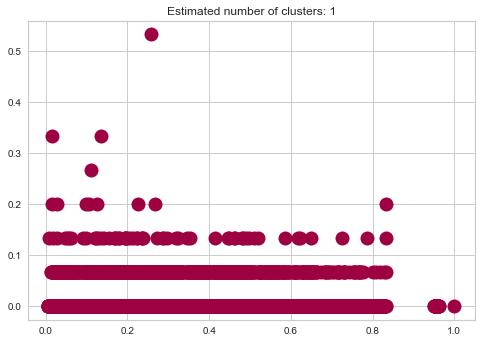

---- eps = 10  ---
Estimated number of clusters: 1
Estimated number of noise points: 0


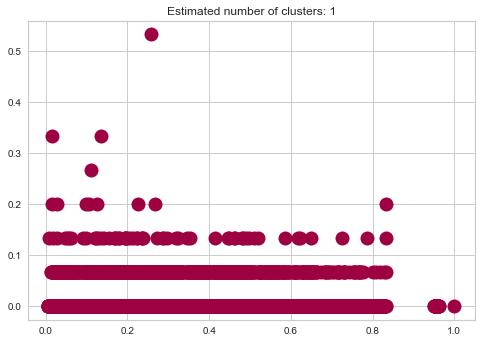

---- eps = 15  ---
Estimated number of clusters: 1
Estimated number of noise points: 0


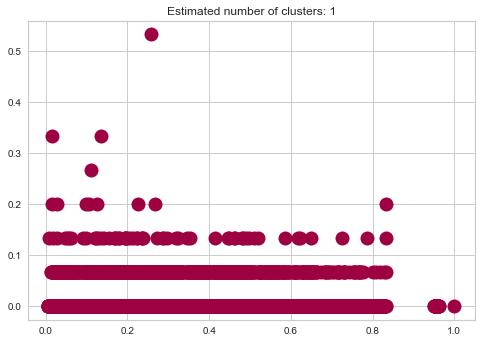

In [12]:
for k in [0.1, 0.5, 1, 2, 5, 10, 15] :
        
    print('---- eps =', k, ' ---')
        
    db = DBSCAN(eps = k, min_samples = 100).fit(X)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_
    
    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)
    
    print("Estimated number of clusters: %d" % n_clusters_)
    print("Estimated number of noise points: %d" % n_noise_)
        
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_member_mask = labels == k

        xy = X[class_member_mask & core_samples_mask]
        plt.plot(
            xy.iloc[:, 0],
            xy.iloc[:, 1],
            "o",
            markerfacecolor = tuple(col),
            markeredgecolor = "k",
            markersize = 14,
        )

        xy = X[class_member_mask & ~core_samples_mask]
        plt.plot(
            xy.iloc[:, 0],
            xy.iloc[:, 1],
            "o",
            markerfacecolor = tuple(col),
            markeredgecolor = "k",
            markersize = 6,
        )

    plt.title("Estimated number of clusters: %d" % n_clusters_)
    plt.show()

Aucun cluster n'est perçu par le modèle, la densité de bons clients étant faible comparée à celle des clients uniques. De plus, l'algorithme n'est pas adapté à la taille de notre dataset, trop volumineux ici. 

# <a class="anchor" id="chapter4">IV. Visualisation avec tSNE </a>

La méthode Kmeans semble donc être la plus adaptée à notre cas. Utilisons maintenant la visualisation tSNE pour voir la répartition des clusters.

In [13]:
X_gc = RFM_MinMax.loc[RFM_MinMax['Frequence'] > 0]
X_bc = RFM_MinMax.loc[RFM_MinMax['Frequence'] == 0].sample(frac = 0.08)
X = pd.concat([X_gc, X_bc])

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10217 samples in 0.012s...
[t-SNE] Computed neighbors for 10217 samples in 0.401s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10217
[t-SNE] Computed conditional probabilities for sample 2000 / 10217
[t-SNE] Computed conditional probabilities for sample 3000 / 10217
[t-SNE] Computed conditional probabilities for sample 4000 / 10217
[t-SNE] Computed conditional probabilities for sample 5000 / 10217
[t-SNE] Computed conditional probabilities for sample 6000 / 10217
[t-SNE] Computed conditional probabilities for sample 7000 / 10217
[t-SNE] Computed conditional probabilities for sample 8000 / 10217
[t-SNE] Computed conditional probabilities for sample 9000 / 10217
[t-SNE] Computed conditional probabilities for sample 10000 / 10217
[t-SNE] Computed conditional probabilities for sample 10217 / 10217
[t-SNE] Mean sigma: 0.003319
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.156380
[t-SNE] KL

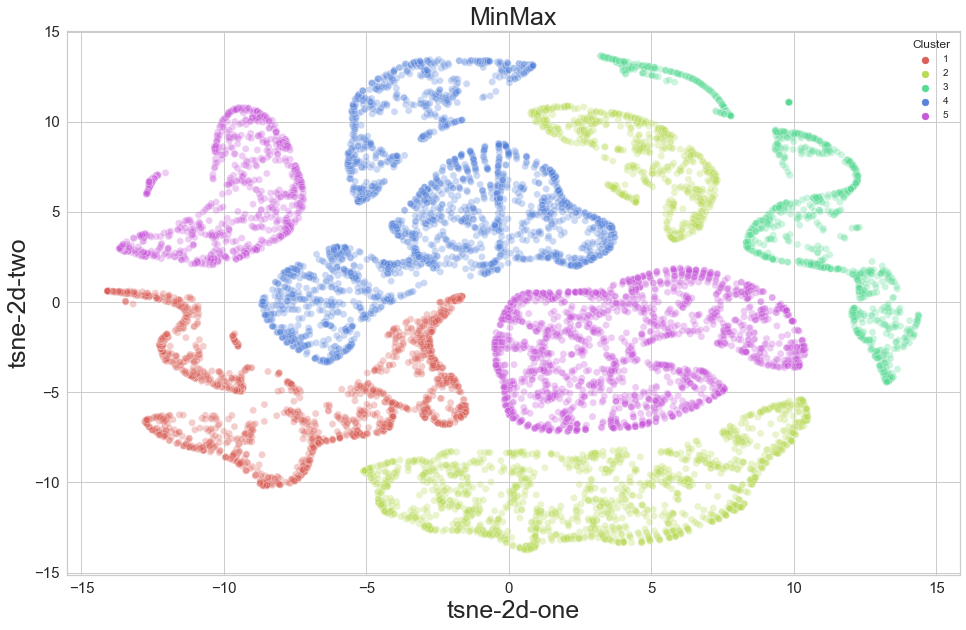

In [14]:
X_subset = pd.DataFrame()
    
time_start = time.time()

tsne = TSNE(n_components = 2, verbose = 1, perplexity = 40, n_iter = 300)

tsne_results = tsne.fit_transform(X)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time() - time_start))

X_subset['tsne-2d-one'] = tsne_results[:, 0]
X_subset['tsne-2d-two'] = tsne_results[:, 1]
X_subset['Cluster'] = list(X['Cluster'])

plt.figure(figsize = (16, 10))
sns.scatterplot(
    x = 'tsne-2d-one', y = 'tsne-2d-two',
    hue = 'Cluster',
    palette = sns.color_palette("hls", 5),
    data = X_subset,
    legend = "full",
    alpha = 0.3
)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel("tsne-2d-one", fontsize = 25)
plt.ylabel("tsne-2d-two", fontsize = 25)
plt.title('MinMax', fontsize = 25)
plt.show()

# <a class="anchor" id="chapter5">V. K-means : ajout de variables </a>

Maintenant que l'on a déterminé que la meilleure approche est K-means, et que la normalisation MinMax semble la plus adaptée, essayons d'ajouter des variables au dataset. 
Les variables ajoutées sont : 

 - le nombre d'article moyen
 - la note moyenne de satisfaction

In [35]:
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": rs,
}

## <a class="anchor" id="section_5_1">1. Déterminer le nombre de clusters optimal (Méthode du coude)</a> 

In [36]:
X = pd.read_csv('Plus_MinMax.csv', index_col = 'Unnamed: 0')

Déterminons le nombre optimal de clusters pour le dataset étendu.

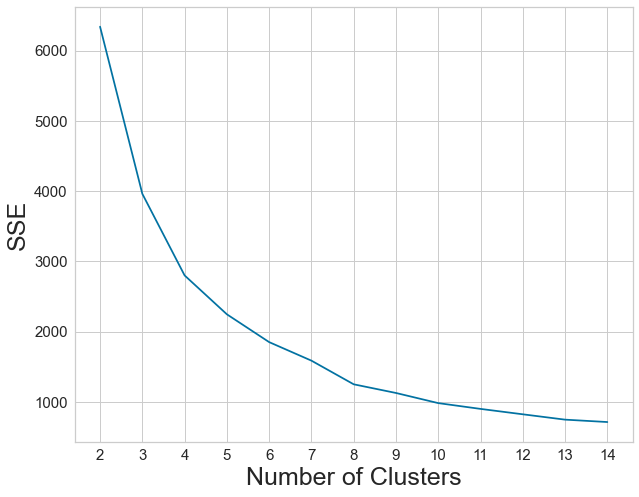

Le nombre de clusters optimal est 5


In [37]:
sse = []

for k in range(2, 15):
    
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(X)
    sse.append(kmeans.inertia_)
        
plt.figure(figsize = (10, 8))
plt.plot(range(2, 15), sse)
plt.xticks(range(2, 15),fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel("Number of Clusters", fontsize = 25)
plt.ylabel("SSE", fontsize = 25)     
        
plt.show()
    
kl = KneeLocator(
range(2, 15), sse, curve = "convex", direction = "decreasing"
)

print('Le nombre de clusters optimal est {}'.format(kl.elbow))


##  <a class="anchor" id="section_5_2">2. Application Kmeans</a>

In [38]:
k = 5

kmeans = KMeans(n_clusters = k, **kmeans_kwargs)
kmeans.fit(X)
    
print('La valeur SSE la plus basse est :', kmeans.inertia_)
print('Nombre de clusters :', k)
print('Il a fallu {} itérations.'.format(kmeans.n_iter_))

#Répartition des utilisateurs dans les clusters
unique, counts = np.unique(kmeans.labels_, return_counts=True)
clusters = pd.DataFrame(data = zip(unique + 1, counts), columns = ['Clusters', 'Nb of Users']).set_index('Clusters')
clusters['% users'] = round(clusters['Nb of Users']/len(X), 2)*100
display(clusters)
X['Cluster'] = [x + 1 for x in kmeans.labels_]    

#Calcul des moyenens et écart-type des variables par 
Y = pd.read_csv('Plus_subset.csv', index_col = 'Unnamed: 0')

Y['Cluster'] = [x + 1 for x in kmeans.labels_]        
cm_moy = sns.light_palette("red", as_cmap = True)
cm_std = sns.light_palette("blue", as_cmap = True)
    
print('-----')
print('Moyenne des variables par cluster')
moy = Y.groupby(by = ['Cluster'], axis = 0, as_index = False).mean().set_index('Cluster')
display(moy.style.background_gradient(cmap=cm_moy).set_precision(3))

print('-----')
print('Médiane des variables par cluster')
moy = Y.groupby(by = ['Cluster'], axis = 0, as_index = False).median().set_index('Cluster')
display(moy.style.background_gradient(cmap = cm_moy).set_precision(3))

print('-----')
print('Ecart-type des variables par cluster')
std = Y.groupby(by = ['Cluster'], axis = 0, as_index = False).std().set_index('Cluster')
display(std.style.background_gradient(cmap = cm_std).set_precision(3))
    
Y = Y.drop('Cluster', axis = 1)

La valeur SSE la plus basse est : 2245.6153564588603
Nombre de clusters : 5
Il a fallu 9 itérations.


,Nb of Users,% users
Clusters,,
1,11295,12.0
2,15240,16.0
3,31550,33.0
4,13273,14.0
5,23362,25.0


-----
Moyenne des variables par cluster


,Recence,Frequence,Montant,Average_nb_items,Review_score
Cluster,,,,,
1,440.872,1.032,158.329,1.097,3.686
2,182.041,1.044,161.490,1.095,3.696
3,170.758,1.038,160.497,1.079,4.997
4,289.467,1.020,193.698,1.210,1.223
5,436.518,1.030,163.449,1.085,4.998


-----
Médiane des variables par cluster


,Recence,Frequence,Montant,Average_nb_items,Review_score
Cluster,,,,,
1,428.000,1.000,104.580,1.000,4.000
2,184.000,1.000,107.740,1.000,4.000
3,168.000,1.000,107.220,1.000,5.000
4,264.000,1.000,120.610,1.000,1.000
5,425.000,1.000,105.180,1.000,5.000


-----
Ecart-type des variables par cluster


,Recence,Frequence,Montant,Average_nb_items,Review_score
Cluster,,,,,
1,95.807,0.188,205.649,0.321,0.475
2,73.507,0.243,207.546,0.334,0.461
3,72.403,0.239,209.907,0.291,0.041
4,144.095,0.145,293.775,0.487,0.417
5,95.036,0.187,227.059,0.304,0.033


Après ajout des deux variables, on observe trois groupes intéressants : 2, 3 et 4.

Les groupes 2 et 3 montrent les Récense les plus basses, ainsi que les Fréquences le plus hautes dans le cluster. Ces clusters possèdent également les notes de satisfaction les plus élevées. Cependant, les valeurs Montant et Nombre moyen d'items ne sont pas les plus élevées. 

Au contraire, le groupe 4 montre une Récense plus grande, une Fréquence faible mais avec un Montant et un nombre moyen d'items élevé. Cependant la note de satisfaction moyenne pour ce groupe est très bas.

Nous avons donc deux groupes de clients qui viennent souvent, dépense moins mais régulièrement, et qui sont satisfaits des services du site, et un groupe de gens ayant dépensé une grande somme en quelques fois, qui ne viennent pas souvent et qui ne semblent pas satisfaits de leur expérience en tant que client. 

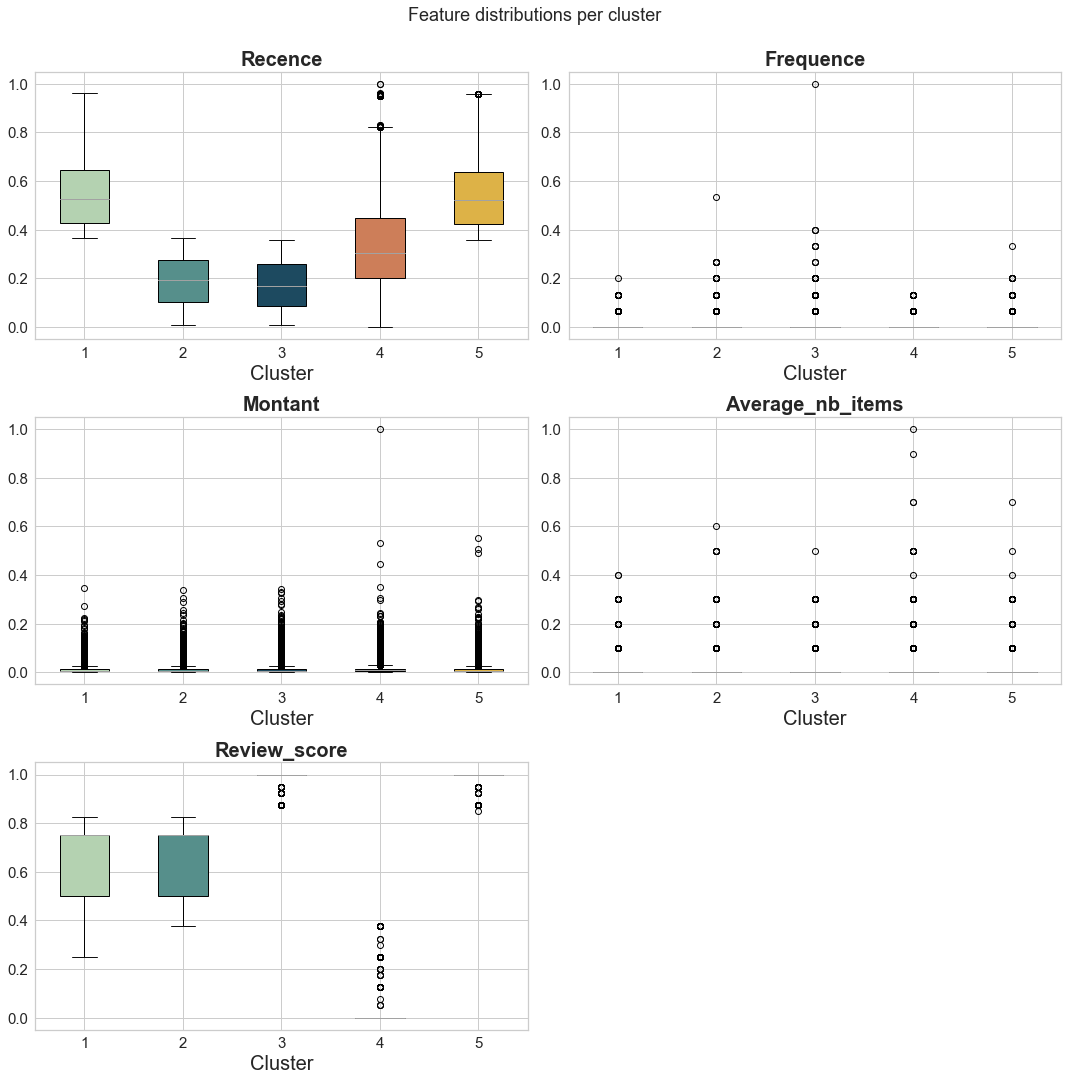

In [20]:
cluster_colors = ['#b4d2b1', '#568f8b', '#1d4a60', '#cd7e59', '#ddb247', '#d15252']

features = kmeans.feature_names_in_
ncols = 2
nrows = len(features) // ncols + (len(features) % ncols > 0)
fig = plt.figure(figsize = (15, 15))

for n, feature in enumerate(features):
    ax = plt.subplot(nrows, ncols, n + 1)
    box = X[[feature, 'Cluster']].boxplot(by='Cluster', ax = ax, return_type = 'both', patch_artist = True)
    
    for row_key, (ax, row) in box.iteritems():
        ax.set_xlabel('Cluster', fontsize = 20)
        ax.set_title(feature,fontweight = "bold", fontsize = 20)
        plt.xticks(fontsize = 15)
        plt.yticks(fontsize = 15)
        for i, box in enumerate(row['boxes']):
            box.set_facecolor(cluster_colors[i])
                
                
fig.suptitle('Feature distributions per cluster', fontsize = 18, y = 1)   
plt.tight_layout()
plt.show()                

## <a class="anchor" id="section_5_3">3. Visualisation</a>

In [23]:
X_gc = X.loc[Plus_MinMax['Frequence'] > 0]
X_bc = X.loc[Plus_MinMax['Frequence'] == 0].sample(frac = 0.08)
X = pd.concat([X_gc,X_bc])

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 3457 samples in 0.005s...
[t-SNE] Computed neighbors for 3457 samples in 0.123s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3457
[t-SNE] Computed conditional probabilities for sample 2000 / 3457
[t-SNE] Computed conditional probabilities for sample 3000 / 3457
[t-SNE] Computed conditional probabilities for sample 3457 / 3457
[t-SNE] Mean sigma: 0.017357
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.509216
[t-SNE] KL divergence after 300 iterations: 0.885280
t-SNE done! Time elapsed: 2.9110116958618164 seconds


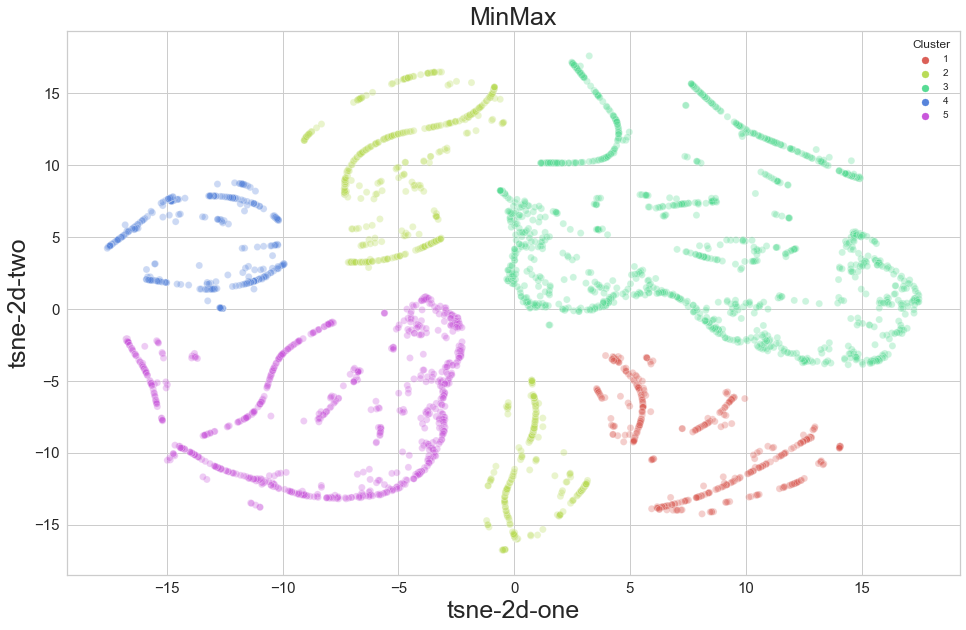

In [24]:
X_subset = pd.DataFrame()
    
time_start = time.time()

tsne = TSNE(n_components = 2, verbose = 1, perplexity = 40, n_iter = 300)

tsne_results = tsne.fit_transform(X)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

X_subset['tsne-2d-one'] = tsne_results[:, 0]
X_subset['tsne-2d-two'] = tsne_results[:, 1]
X_subset['Cluster'] = list(X['Cluster'])

plt.figure(figsize = (16,10))
sns.scatterplot(
    x = 'tsne-2d-one', y = 'tsne-2d-two',
    hue = 'Cluster',
    palette = sns.color_palette("hls", 5),
    data = X_subset,
    legend = "full",
    alpha = 0.3
)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel("tsne-2d-one",fontsize = 25)
plt.ylabel("tsne-2d-two",fontsize = 25)
plt.title('MinMax', fontsize = 25)
plt.show()